In [1]:
import numpy as np
import sys
from scipy.stats import entropy
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import matplotlib.font_manager as font_manager 
from matplotlib.pyplot import gca
import qutip as qt
from qutip_qip.operations import cnot, hadamard_transform
import scipy as sc
# path_main = '/Users/stepanvinckevich/Desktop/IMPORTANT NOW/QIS QRL/CODE/QRC/'
path_main = ''
path_EVAL = path_main + 'EVALUATION/'
path_EVAL_MEASBRIDGE = path_EVAL + 'MEASBRIDGE/'
path_EVAL_HORC = path_EVAL + 'HORC/'
path_CHAOS_SIGNAL = path_EVAL_HORC + 'CHAOS/'
path_SIGNAL = path_EVAL_HORC + 'NOISY/'
sys.path.append(path_main)

np.random.seed(20)

In [2]:
# Number of qubits in reservoirs A and B
n_qubitsA = 3
k_power_A = 0

n_qubitsB = 3
k_power_B = 0

# Evolution timestep
timestep = 0.3
multiplexing = 10
# Trace preserving tolerance
tp_tol = 1e-5

n_qubits_total = n_qubitsA + n_qubitsB

In [3]:
# Hamiltonian of A
if k_power_A != 0:
    hamiltonianA = qt.Qobj(np.load(f'/content/gdrive/My Drive/QRC/hamiltonians/hamiltonian{n_qubitsA}_{k_power_A}.npy'), dims=[[2]*n_qubitsA, [2]*n_qubitsA])
else:
    hamiltonianA = qt.Qobj(np.load(path_main + f'hamiltonians/hamiltonian{n_qubitsA}.npy'), dims=[[2]*n_qubitsA, [2]*n_qubitsA])
identityA = qt.identity(2**n_qubitsA)
identityA.dims = [[2]*n_qubitsA, [2]*n_qubitsA]

# Hamiltonian of B
if k_power_B != 0:
    hamiltonianB = qt.Qobj(np.load(f'/content/gdrive/My Drive/QRC/hamiltonians/hamiltonian{n_qubitsB}_{k_power_B}.npy'), dims=[[2]*n_qubitsB, [2]*n_qubitsB])
else:
    hamiltonianB = qt.Qobj(np.load(path_main + f'hamiltonians/hamiltonian{n_qubitsB}.npy'), dims=[[2]*n_qubitsB, [2]*n_qubitsB])
identityB = qt.identity(2**n_qubitsB)
identityB.dims = [[2]*n_qubitsB, [2]*n_qubitsB]

# Total hamiltonian
hamiltonian = qt.tensor(hamiltonianA, identityB) + qt.tensor(identityA, hamiltonianB)
# hamiltonian = hamiltonianA

In [4]:
# Evolution step propagator
propagator = qt.propagator(hamiltonian, timestep)
propagator_dag = propagator.dag().full()
propagator = propagator.full()

# Evolution of entanglement sites a and b (now taken as identity)
prop_a = np.eye(2)
prop_b = np.eye(2)

# Operations
cnot_mtx = cnot(2, control=0, target=1).full()
hadamard = hadamard_transform().full()
cnot_mtx_backward = cnot(2, control=1, target=0).full()

# Entanglement channel
#ent_transform = cnot_mtx @ (np.kron(hadamard @ prop_a, prop_b))
ent_transform = cnot_mtx @ cnot_mtx_backward @ cnot_mtx @ (np.kron(hadamard @ prop_a, prop_b))

ent_transform_dag = np.kron(np.eye(2**(n_qubitsA - 1)), np.kron(ent_transform.T.conj(), np.eye(2**(n_qubitsB - 1))))
ent_transform = np.kron(np.eye(2**(n_qubitsA - 1)), np.kron(ent_transform, np.eye(2**(n_qubitsB - 1))))

#################################################

b = np.random.uniform(0,1/3)
c = np.random.uniform(0,1/3)

P0 = qt.basis(2,0) 
P1 = qt.basis(2,1)


P00 = qt.tensor(P0,P0)
P01 = qt.tensor(P0,P1)
P10 = qt.tensor(P1,P0)
P11 = qt.tensor(P1,P1)

psi00 = b * P00 + np.sqrt(1 - b**2) * P11 
B00 = psi00 * psi00.dag()
B00 = B00.full()

psi11 = -b * P11 + np.sqrt(1 - b**2) * P00 
B11 = psi11 * psi11.dag()
B11 = B11.full()

psi01 = c * P01 + np.sqrt(1 - c**2) * P10 
B01 = psi01 * psi01.dag()
B01 = B01.full()

psi10 = -c * P10 + np.sqrt(1 - c**2) * P01 
B10 = psi10 * psi10.dag()
B10 = B10.full()

PB00_dag = np.kron(np.eye(2**(n_qubitsA - 1)), np.kron(B00.T.conj(), np.eye(2**(n_qubitsB - 1))))
PB00 = np.kron(np.eye(2**(n_qubitsA - 1)), np.kron(B00, np.eye(2**(n_qubitsB - 1))))

PB11_dag = np.kron(np.eye(2**(n_qubitsA - 1)), np.kron(B11.T.conj(), np.eye(2**(n_qubitsB - 1))))
PB11 = np.kron(np.eye(2**(n_qubitsA - 1)), np.kron(B11, np.eye(2**(n_qubitsB - 1))))

PB01_dag = np.kron(np.eye(2**(n_qubitsA - 1)), np.kron(B01.T.conj(), np.eye(2**(n_qubitsB - 1))))
PB01 = np.kron(np.eye(2**(n_qubitsA - 1)), np.kron(B01, np.eye(2**(n_qubitsB - 1))))

PB10_dag = np.kron(np.eye(2**(n_qubitsA - 1)), np.kron(B10.T.conj(), np.eye(2**(n_qubitsB - 1))))
PB10 = np.kron(np.eye(2**(n_qubitsA - 1)), np.kron(B10, np.eye(2**(n_qubitsB - 1))))



######################


In [5]:
# Initial density matrix
init_state = qt.tensor(*[qt.rand_ket(2) for _ in range(n_qubits_total)])
init_state = init_state * init_state.dag()
init_state = init_state.full()

# np.save(f"TF/init_state{n_qubits}.npy", init_state)
# init_state = np.load(f"TF/init_state{n_qubits}.npy")

In [6]:
# Z observable and I/2
local_obs = np.array([[1., 0.], [0., -1.]])
identity_ent = np.eye(2)/2
identity_total = np.eye(2**n_qubits_total)

In [7]:
def get_depol_ops(site):
    sx = np.kron(np.eye(2**site), np.kron(np.array([[0., 1.], [1., 0.]]), np.eye(2**(n_qubits_total - site - 1))))
    sy = np.kron(np.eye(2**site), np.kron(np.array([[0., -1j], [1j, 0.]]), np.eye(2**(n_qubits_total - site - 1))))
    sz = np.kron(np.eye(2**site), np.kron(np.array([[1., 0.], [0., -1.]]), np.eye(2**(n_qubits_total - site - 1))))
    return sx, sy, sz

In [8]:
def ptrace(mtx, hold):
    """Performs partial trace of state with only one site #hold remains"""
    indexes = list(range(2*n_qubits_total))
    axis_order = [indexes.pop(hold), indexes.pop(hold + n_qubits_total - 1)]
    axis_order = indexes + axis_order
    mtx = np.transpose(np.reshape(mtx, [2]*2*n_qubits_total), axis_order)
    return np.trace(np.reshape(mtx, (2**(n_qubits_total-1), 2**(n_qubits_total-1), 2, 2)))

def evolution_step(state):
    """Simple application of evolution step propagator"""
    state = propagator @ state @ propagator_dag
    # assert np.abs(np.trace(state) - 1.) < tp_tol, f"Trace is not preserved.{np.trace(state)}"
    return state / np.trace(state)

def evolution_step_obs(obs):
    """Simple application of evolution step propagator"""
    obs = propagator_dag @ obs @ propagator
    return obs

In [9]:
depol_ops = [get_depol_ops(site) for site in range(n_qubits_total)]

In [10]:
# FOR TESTING NONSELECTIVE MEASUREMENTS DONT FORGET TO CHANGE PARAMETER rand !!!!!


def entangled_channel_step(state, p, rand = True):
    """Application of entanglement channel with and depolarization channel with probability of depolarization 'p'"""
    if not rand:
        state = ent_transform @ state @ ent_transform_dag
    else:
        state = PB00 @ state @ PB00_dag + PB11 @ state @ PB11_dag + PB10 @ state @ PB10_dag + PB01 @ state @ PB01_dag
        
    if p != 0:
        for site in [0, 1, 4, 5]:
            state = (1 - p) * state + p/3 * sum([depol_ops[site][i] @ state @ depol_ops[site][i] for i in range(3)])
    return state / np.trace(state)

def entangled_channel_step_obs(state, p, rand = True):
    """Application of entanglement channel with and depolarization channel with probability of depolarization 'p'"""
    if not rand:
        state = ent_transform_dag @ state @ ent_transform
    else:
        state = PB00_dag @ state @ PB00 + PB11_dag @ state @ PB11 + PB10_dag @ state @ PB10 + PB01_dag @ state @ PB01
    if p != 0:
        for site in [0, 1, 4, 5]:
            state = (1 - p) * state + p/3 * sum([depol_ops[site][i] @ state @ depol_ops[site][i] for i in range(3)])
    return state

In [11]:
tracing_krauss0 = np.kron(np.array([1, 0]), np.eye(2**(n_qubits_total - 1)))
tracing_krauss1 = np.kron(np.array([0, 1]), np.eye(2**(n_qubits_total - 1)))

tracing_krauss0_last = np.kron(np.eye(2**(n_qubits_total - 1)), np.array([1, 0]))
tracing_krauss1_last = np.kron(np.eye(2**(n_qubits_total - 1)), np.array([0, 1]))

In [12]:
def get_encoding_krauss(inp):
    tensor_product_krauss = np.eye(2**(n_qubits_total - 1)).ravel()
    tensor_product_krauss = np.kron(np.array([np.sqrt(inp), np.sqrt(1. - inp)]), tensor_product_krauss).reshape(2**(n_qubits_total), 2**(n_qubits_total-1))
    return tensor_product_krauss

def get_encoding_krauss_last(inp):
    tensor_product_krauss = np.eye(2**(n_qubits_total - 1)).ravel()
    tensor_product_krauss = np.kron(tensor_product_krauss, np.array([np.sqrt(inp), np.sqrt(1. - inp)])).reshape(2**(n_qubits_total-1), 2**(n_qubits_total)).T
    return tensor_product_krauss

In [13]:
W_inp = np.random.uniform()
W_connA = np.random.uniform(size=(n_qubits_total - 1)*multiplexing)
W_connB = np.random.uniform(size=(n_qubits_total - 1)*multiplexing)

W_connA = W_connA / np.sum(W_connA) / W_connA.shape[0]
W_connB = W_connB / np.sum(W_connB) / W_connB.shape[0]

In [14]:
def encoding_step(state, inp, prev_out=None):
    if prev_out is not None:
        horc_inp = W_inp * inp + (1 - W_inp) * W_connA @ (prev_out + 1)/2
    else:
        horc_inp = inp
        
    enc_krauss = get_encoding_krauss(horc_inp)
    state = tracing_krauss0 @ state @ tracing_krauss0.T + tracing_krauss1 @ state @ tracing_krauss1.T
    state = enc_krauss @ state @ enc_krauss.T

    if prev_out is not None:
        horc_inp = W_connB @ (prev_out + 1)/2
    else:
        horc_inp = inp
    
    enc_krauss = get_encoding_krauss_last(horc_inp)
    state = tracing_krauss0_last @ state @ tracing_krauss0_last.T + tracing_krauss1_last @ state @ tracing_krauss1_last.T
    state = enc_krauss @ state @ enc_krauss.T
    return state

def encoding_step_obs(state, inp, prev_out=None):
    if prev_out is not None:
        horc_inp = W_inp * inp + (1 - W_inp) * W_connA @ (prev_out + 1)/2
    else:
        horc_inp = inp
        
    enc_krauss = get_encoding_krauss(horc_inp)
    state = enc_krauss.T @ state @ enc_krauss
    state = tracing_krauss0.T @ state @ tracing_krauss0 + tracing_krauss1.T @ state @ tracing_krauss1
    
    if prev_out is not None:
        horc_inp = W_connB @ (prev_out + 1)/2
    else:
        horc_inp = inp
    
    enc_krauss = get_encoding_krauss_last(horc_inp)
    state = enc_krauss.T @ state @ enc_krauss
    state = tracing_krauss0_last.T @ state @ tracing_krauss0_last + tracing_krauss1_last.T @ state @ tracing_krauss1_last
    return state

In [15]:
def separated_measurement_step(state, site):
    """Nakajima pipeline"""
    # Qubit #site dm and Z observable application
    one_qubit_dm = ptrace(state, site)
    outcome = np.real(np.trace(local_obs @ one_qubit_dm))
    return state, outcome

In [16]:
def get_mutual_information(state):
    axis_order = list(range(n_qubitsA, n_qubits_total)) + list(range(n_qubitsA + n_qubits_total, 2*n_qubits_total)) + list(
        range(0, n_qubitsA)) + list(range(n_qubits_total, n_qubitsA + n_qubits_total))
    dmA = np.trace(np.reshape(
        np.transpose(np.reshape(state, [2]*2*n_qubits_total), axis_order),
        (2**n_qubitsB, 2**n_qubitsB, 2**n_qubitsA, 2**n_qubitsA)
    ))
    axis_order = list(range(0, n_qubitsA)) + list(range(n_qubits_total, n_qubitsA + n_qubits_total)) + list(
        range(n_qubitsA, n_qubits_total)) + list(range(n_qubitsA + n_qubits_total, 2*n_qubits_total))
    dmB = np.trace(np.reshape(
        np.transpose(np.reshape(state, [2]*2*n_qubits_total), axis_order),
        (2**n_qubitsA, 2**n_qubitsA, 2**n_qubitsB, 2**n_qubitsB)
    ))
    eigsS, _ = np.linalg.eigh(state)
    eigsA, _ = np.linalg.eigh(dmA)
    eigsB, _ = np.linalg.eigh(dmB)
    return entropy(eigsS[eigsS > tp_tol]) - entropy(eigsA[eigsA > tp_tol]) - entropy(eigsB[eigsB > tp_tol])

**KRAUSS OPS TESTED**

###################################################################

In [17]:
state = evolution_step_obs(init_state)
indexes = list(range(2*n_qubits_total))
axis_order = [indexes.pop(0), indexes.pop(n_qubits_total - 1)]
axis_order = axis_order + indexes
state1 = np.transpose(np.reshape(state, [2]*2*n_qubits_total), axis_order)
state1 = np.trace(np.reshape(state1, (2, 2, 2**(n_qubits_total-1), 2**(n_qubits_total-1))))

state2 = tracing_krauss0 @ state @ tracing_krauss0.T + tracing_krauss1 @ state @ tracing_krauss1.T

assert np.linalg.norm(state2 - state1) < 1e-12, "Tracing ops failure in value"
assert state2.shape == (2**(n_qubits_total-1), 2**(n_qubits_total-1)), "Tracing ops failure in shape"

In [18]:
# inp = 0.5
# tensor_product_krauss = get_encoding_krauss(inp)
# state = evolution_step(init_state)
# state1 = encoding_step(state, inp)
# state2 = tensor_product_krauss @ (tracing_krauss0 @ state @ tracing_krauss0.T + tracing_krauss1 @ state @ tracing_krauss1.T) @ tensor_product_krauss.T
# assert np.linalg.norm(state2 - state1) < 1e-12, "Tensor product ops failure in value"
# assert state2.shape == (2**n_qubits_total, 2**n_qubits_total), "Tensor product ops failure in shape"

###################################################################

In [19]:
# signal = np.load('/content/gdrive/My Drive/QRC/data/complex_signal_9_9.npy')
signal = np.load(path_main + 'data/complex_signal_9_9.npy')[::5]
signal = np.concatenate([signal, signal, signal[:200]])
# signal = [np.random.choice(2) for _ in range(2200)]
inp = signal[2000:2200]

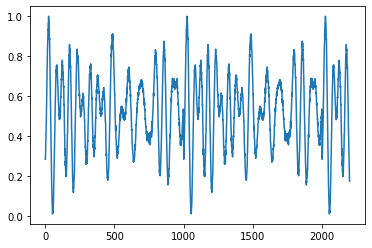

In [20]:
plt.plot(signal)

In [21]:
init_obs = [depol_ops[site][2] for site in range(1, n_qubits_total)]

In [22]:
def get_obs_at_time(obs, timestep, res, dp):
    for n in range(timestep):
        obs = encoding_step_obs(obs, inp[timestep-n], prev_out=res[timestep-n-1].ravel())
        for m in range(multiplexing):
#             obs = entangled_channel_step_obs(obs, dp)
            obs = evolution_step_obs(obs)
    return obs

In [23]:
def evaluate(depolarization_prob):
    # Initialization
    otoc = np.zeros((len(inp), n_qubits_total - 1))
    mutual_information = np.zeros(len(inp))
    result = np.zeros((len(inp), multiplexing, n_qubits_total - 1))
    purity = np.zeros(len(inp))
    state = init_state
    
    for i in range(2000):
        state = encoding_step(state, signal[i])
        state = evolution_step(state)
        # CHANGE rand TO TRUE FOR NONSELECTIVE MEASURMENTS SETUP !!!
#         state = entangled_channel_step(state, depolarization_prob)
    for n in tqdm(range(len(inp))):
        purity[n] = np.real(np.trace(state @ state))
        # Encoding
        state = encoding_step(state, inp[n], prev_out=result[n-1].ravel())
        # Main part
        for m in range(multiplexing):
            # Evolution -> Entanglement -> Evolution
            state = evolution_step(state)
            # CHANGE rand TO TRUE FOR NONSELECTIVE MEASURMENTS SETUP !!!
#             state = entangled_channel_step(state, depolarization_prob)

            for site in range(n_qubits_total - 1):
                state, outcome = separated_measurement_step(state, site + 1)
                result[n, m, site] = outcome
        
        for idx, obs in enumerate(init_obs):
            obs_at_time = get_obs_at_time(obs, n, result, depolarization_prob)
            otoc[n, idx] = np.real(np.trace(state @ obs @ obs_at_time @ obs @ obs_at_time))
        
#         mutual_information[n] = get_mutual_information(state)

    return result, mutual_information, otoc, purity, state

In [24]:
# p = 0
# results, mutual_information, otoc, purity, state = evaluate(p)

p = [0, 0.001, 0.01, 0.1, 0.5]
for prob in p:
    results, mutual_information, otoc, purity, state = evaluate(prob)
    np.save(path_SIGNAL + 'OTOC_p' + str(prob), otoc)
    np.save(path_SIGNAL + 'results_p' + str(prob), results)
    np.save(path_SIGNAL + 'state_p' + str(prob), state)
    np.save(path_SIGNAL + 'purity_p' + str(prob), purity)
    np.save(path_SIGNAL + 'mutual_information_p' + str(prob), mutual_information)


In [25]:
j = 2
prob = p[j]
otoc = np.load(path_SIGNAL + 'otoc_p' + str(prob) + '.npy')

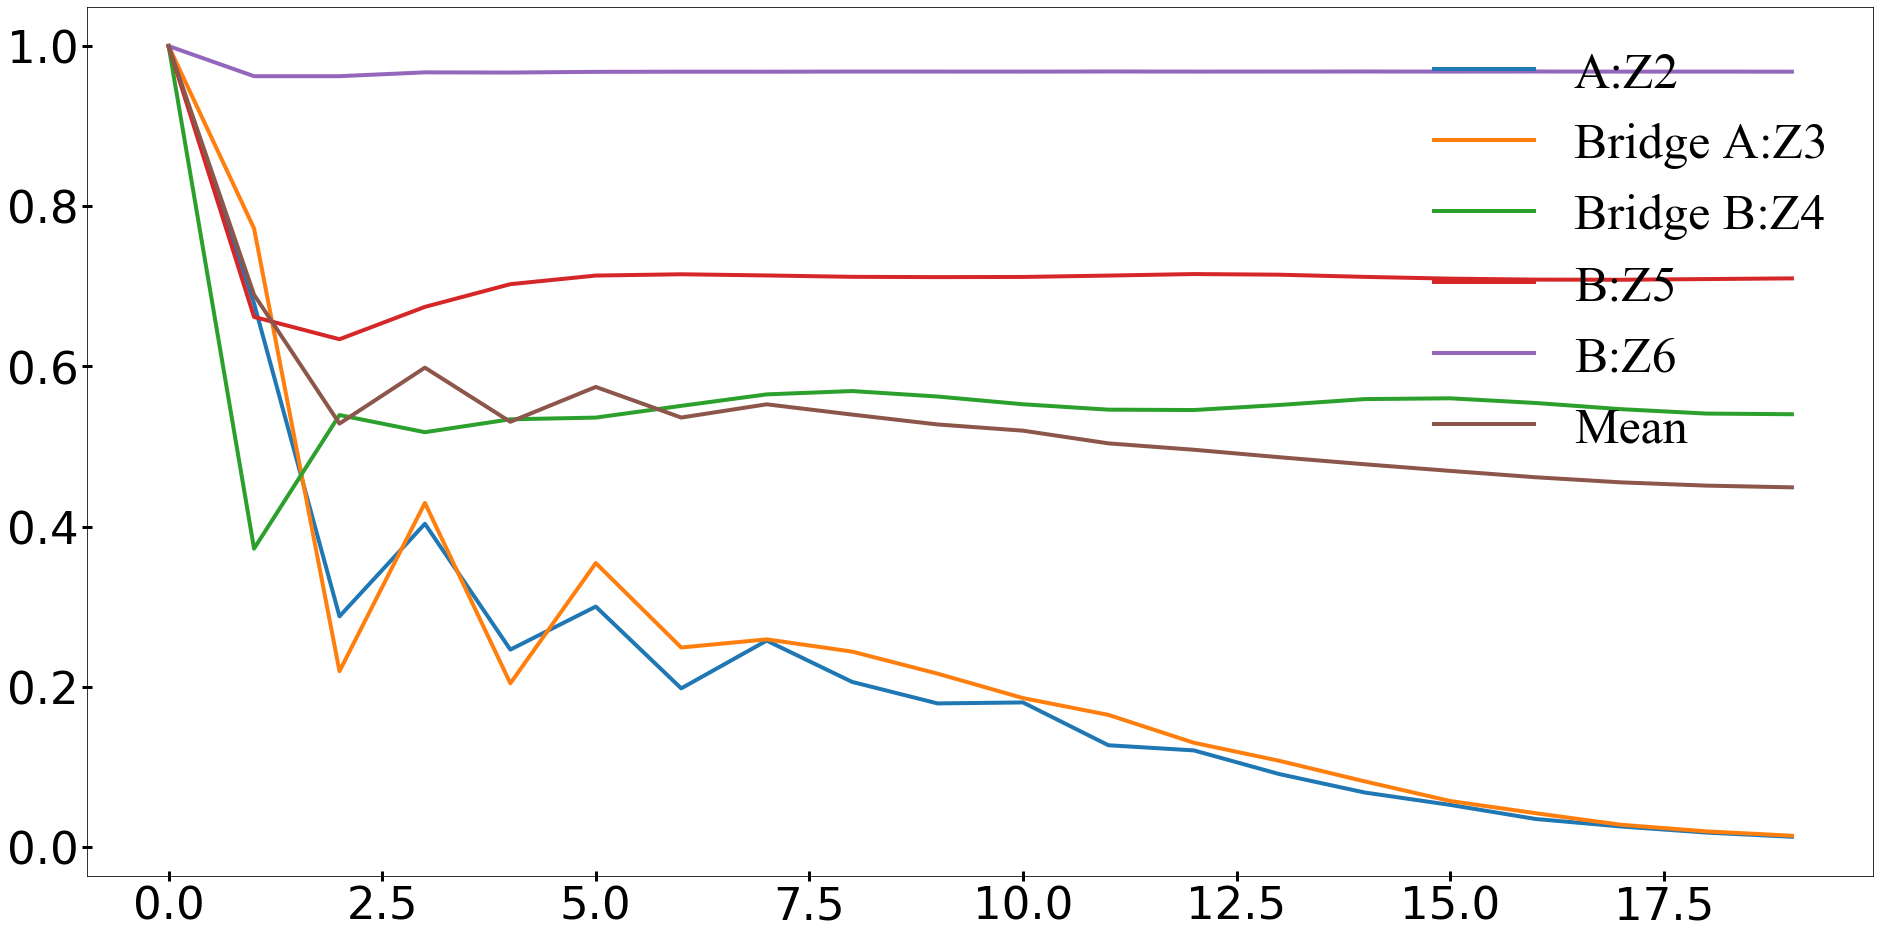

In [33]:

fig = plt.figure(figsize = (32, 16))
font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=25)
font1 = {'family': 'Times New Roman',
        'weight': 'normal',
        'size': 50,
        }
ax = plt.subplot(111)
ax.tick_params(axis='both', which='major', labelsize=45, width = 3, length = 10, direction = 'inout')

#for i in range(5):
#    plt.plot(otoc[:20, i], label = 'Z' + str(i))
    
plt.plot(otoc[:20,0], label = 'A:Z' + str(2), linewidth = 4)
plt.plot(otoc[:20,1], label = 'Bridge A:Z' + str(3), linewidth = 4)
plt.plot(otoc[:20,2], label = 'Bridge B:Z' + str(4),  linewidth = 4)

plt.plot(otoc[:20,3], label = 'B:Z' + str(5), linewidth = 4)
plt.plot(otoc[:20,4], label = 'B:Z' + str(6),  linewidth = 4)

plt.plot(np.mean(otoc[:20], axis=-1), label = 'Mean',  linewidth = 4)
    
plt.legend(frameon=False,loc='upper right', prop = font1)

fig.savefig(path_SIGNAL + 'OTOC_' + str(prob) + '.svg', format='svg', dpi=3000)

In [34]:
def learning(results, offset):
    y_true = np.array(signal[2000-offset:2200-offset]) * 2 - 1
    X = results.reshape(-1, (n_qubits_total - 1) * multiplexing)
    X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
    W = np.linalg.inv(X.T @ X + 1e-7*np.eye(X.shape[1])) @ X.T @ y_true
    return X @ W, y_true

def learning_gen(results, offset):
    y_true = np.array(signal[2000-offset:2100-offset]) * 2 - 1
    y_test = np.array(signal[2100-offset:2200-offset]) * 2 - 1
    X = results.reshape(-1, (n_qubits_total - 1) * multiplexing)
    X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
    X_train = X[:100]
    X_test = X[100:]
    W = np.linalg.inv(X_train.T @ X_train + 1e-18 *np.eye(X_train.shape[1])) @ X_train.T @ y_true
    return X_test @ W, y_test

In [35]:
result_list = [np.load(path_SIGNAL + 'results_p' + str(prob) + '.npy') for prob in p]
i = 0
results = result_list[i]

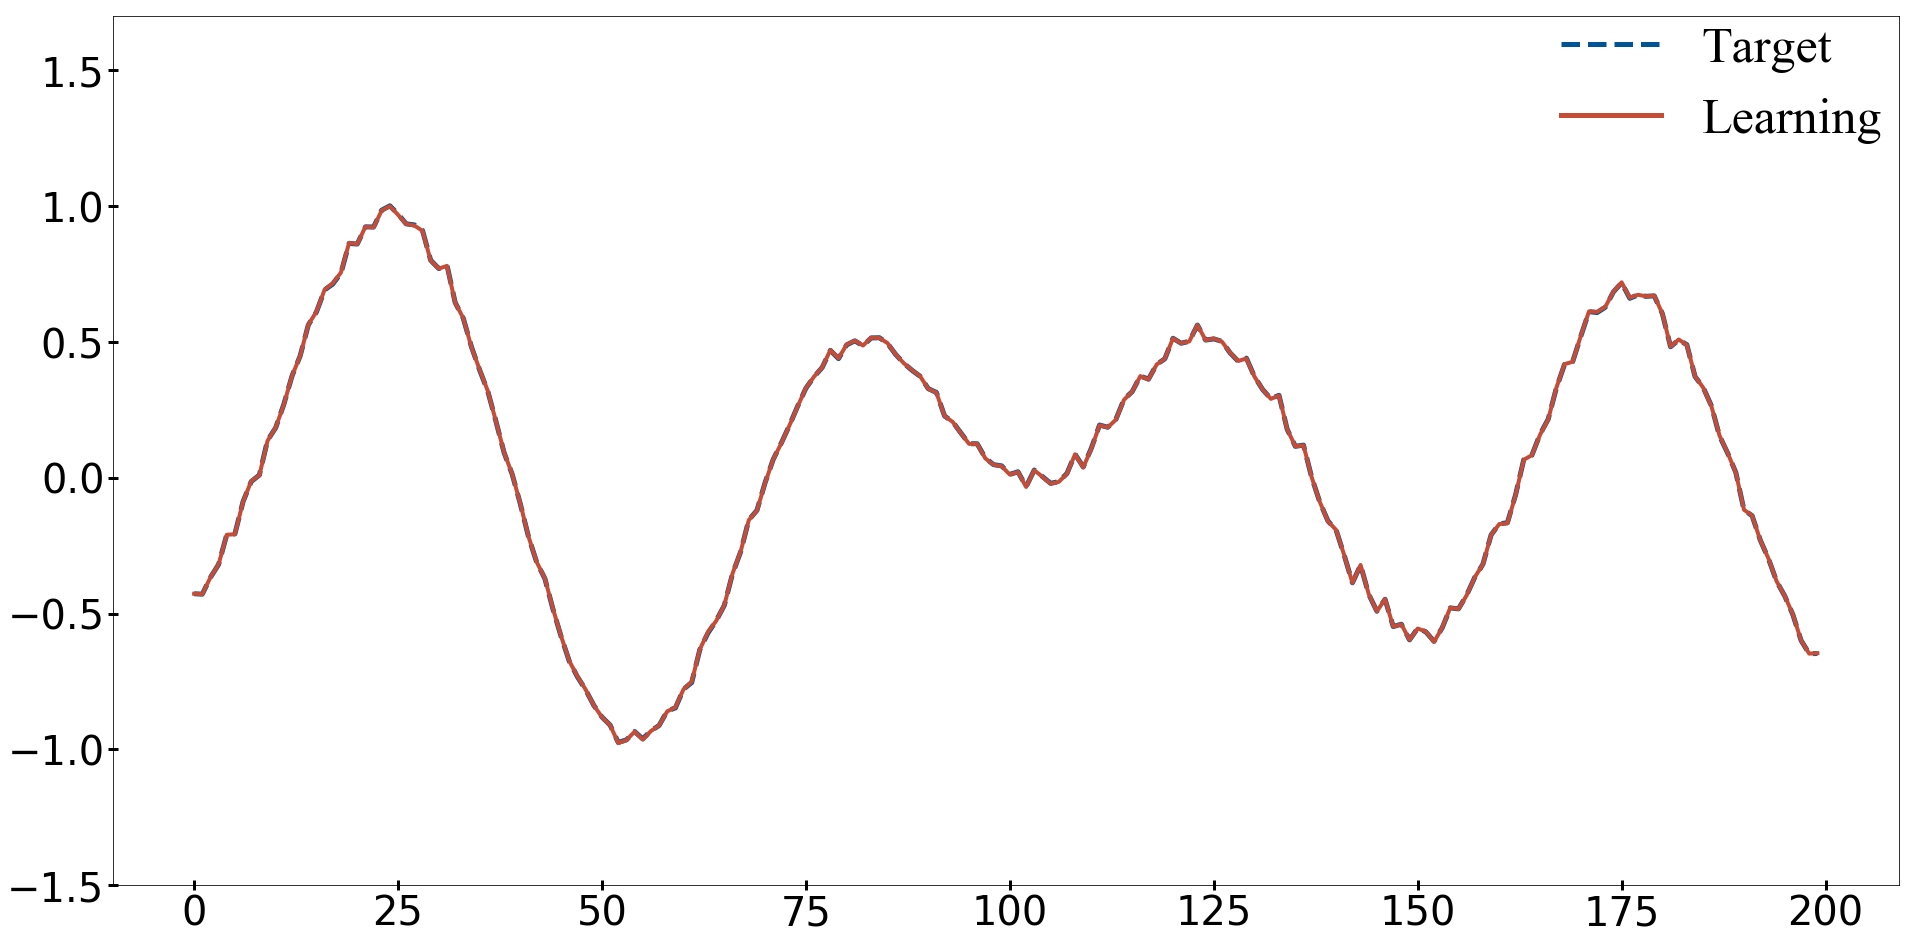

In [36]:
# LEARNING EVALUATION

res, y_true = learning(results, 0)
fig = plt.figure(figsize = (32, 16))
font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=10)
font1 = {'family': 'Times New Roman',
        'weight': 'normal',
        'size': 50,
        }
ax = plt.subplot(111)
ax.tick_params(axis='both', which='major', labelsize=40, width = 3, length = 10, direction = 'inout')
ax.set_ylim(-1.5, 1.7)
plt.plot(y_true, label = 'Target', linewidth=5, linestyle = '--', color = '#005394')
plt.plot(res, label = 'Learning',linewidth=4, color = '#C54C36')
leg = plt.legend(frameon=False, loc=(0.8,0.83), prop = font1)
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
plt.setp(leg_lines, linewidth=5)

fig.savefig(path_SIGNAL + 'LEARNING_p' + str(p[i])+ '.svg', format='svg', dpi=3000)

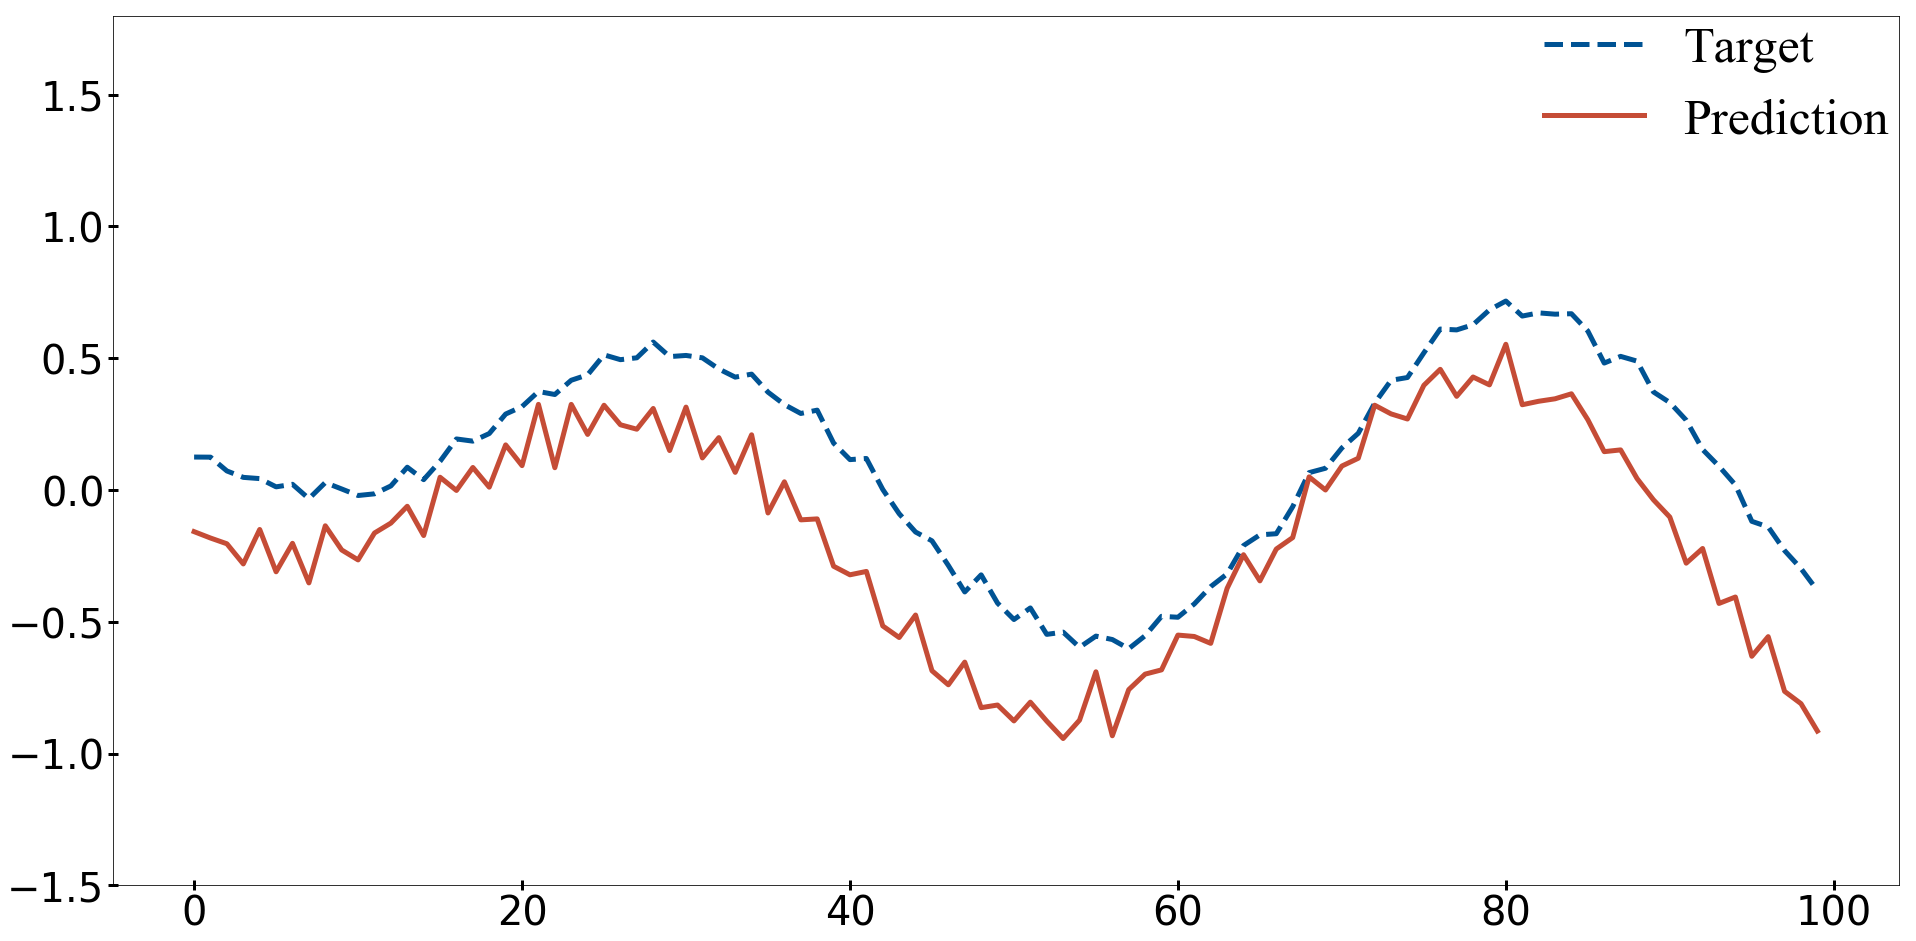

In [37]:
# GENERALIZATION



offset = 5
res_gen, y_true_gen = learning_gen(results, offset)

fig = plt.figure(figsize = (32, 16))
font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=10)
font1 = {'family': 'Times New Roman',
        'weight': 'normal',
        'size': 50,
        }
ax = plt.subplot(111)
ax.tick_params(axis='both', which='major', labelsize=40, width = 3, length = 10, direction = 'inout')
ax.set_ylim(-1.5, 1.8)

plt.plot(y_true_gen, label = 'Target', linewidth=5, linestyle = '--', color = '#005394')
plt.plot(res_gen, label = 'Prediction',linewidth=5, color = '#C54C36')
leg = plt.legend(frameon=False, loc=(0.79,0.83), prop = font1)
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
plt.setp(leg_lines, linewidth=5)


fig.savefig(path_SIGNAL + 'PREDICTION_offset_'+ str(offset) + '_p' + str(p[i]) +'.svg', format='svg', dpi=3000)

In [38]:

def get_memory_acc(result):
    acc = []
    for i in range(50):
        res, y_true = learning(result, i)
        acc.append((np.mean(res * y_true) - np.mean(res) * np.mean(y_true))**2/np.var(res)/np.var(y_true))
    return acc


def learn_acc(d_max, result):
    acc = []
    for d in range(d_max):
        res, y_true = learning_gen(result, d)
        acc.append(np.linalg.norm(res - y_true))
        #acc.append(np.sum(res - y_true)**2)
        
    return np.array(acc)

mem_acc_list = []
mem_cap_list = []
learning_acc_list = []

for results in result_list:
    memory_acc = get_memory_acc(results)
    memory_cap = np.array([np.mean(memory_acc[0: d]) for d in range(1, len(memory_acc))])
    learning_acc = learn_acc(20,results)
    
    mem_acc_list.append(memory_acc)
    mem_cap_list.append(memory_cap)
    learning_acc_list.append(learning_acc)


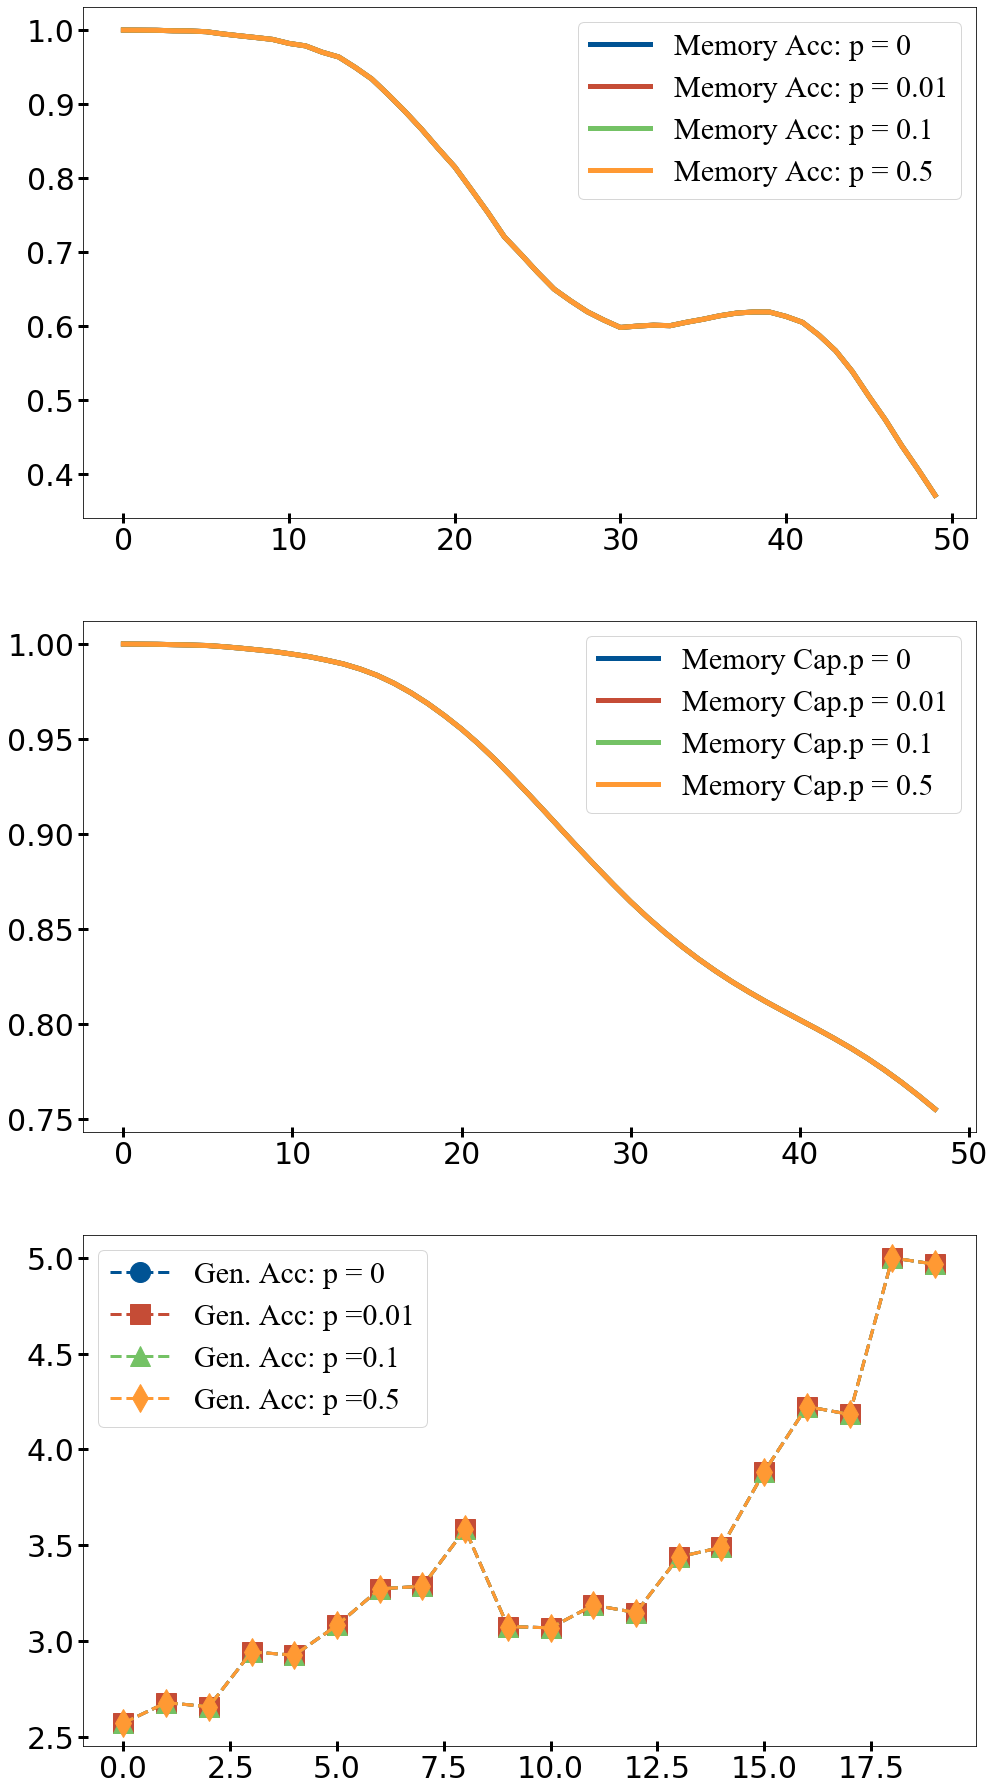

In [39]:


fig, ax = plt.subplots(3, figsize = (16,32))
#fig = plt.figure(figsize = (32, 16))
font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=25)
font1 = {'family': 'Times New Roman',
        'weight': 'normal',
        'size': 30,
        }

ax[0].tick_params(axis='both', which='major', labelsize=30, width = 3, length = 10, direction = 'inout')
ax[1].tick_params(axis='both', which='major', labelsize=30, width = 3, length = 10, direction = 'inout')
ax[2].tick_params(axis='both', which='major', labelsize=30, width = 3, length = 10, direction = 'inout')


ax[0].plot(mem_acc_list[0], label = 'Memory Acc: p = 0', linewidth = 5, color = '#005394')
ax[0].plot(mem_acc_list[2], label = 'Memory Acc: p = 0.01', linewidth = 5, color = '#C54C36')
ax[0].plot(mem_acc_list[3], label = 'Memory Acc: p = 0.1', linewidth = 5, color = '#74C265')
ax[0].plot(mem_acc_list[4], label = 'Memory Acc: p = 0.5', linewidth = 5, color = '#FF9933')
ax[0].legend(loc = 'upper right', prop = font1)

ax[1].plot(mem_cap_list[0], label = 'Memory Cap.p = 0', linewidth = 5, color = '#005394')
ax[1].plot(mem_cap_list[2], label = 'Memory Cap.p = 0.01', linewidth = 5, color = '#C54C36')
ax[1].plot(mem_cap_list[3], label = 'Memory Cap.p = 0.1', linewidth = 5, color = '#74C265')
ax[1].plot(mem_cap_list[4], label = 'Memory Cap.p = 0.5', linewidth = 5, color = '#FF9933')
ax[1].legend(loc = 'upper right',  prop = font1)



ax[2].plot(learning_acc_list[0], label = 'Gen. Acc: p = 0', linewidth = 3, linestyle = '--',  marker = 'o',markersize = 20, color = '#005394')
ax[2].plot(learning_acc_list[2], label = 'Gen. Acc: p =0.01', linewidth = 3, linestyle = '--',  marker = 's',markersize = 20, color = '#C54C36')
ax[2].plot(learning_acc_list[3], label = 'Gen. Acc: p =0.1', linewidth = 3, linestyle = '--',  marker = '^',markersize = 20, color = '#74C265')
ax[2].plot(learning_acc_list[4], label = 'Gen. Acc: p =0.5', linewidth = 3, linestyle = '--',  marker = 'd',markersize = 20, color = '#FF9933')
ax[2].legend(loc = 'best',  prop = font1)

fig.savefig(path_SIGNAL + 'TASKS_BENCHMARKS' + '.svg', format='svg', dpi=3000)